In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('diabetes_dataset.csv')

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [6]:
import plotly.express as px
%matplotlib inline

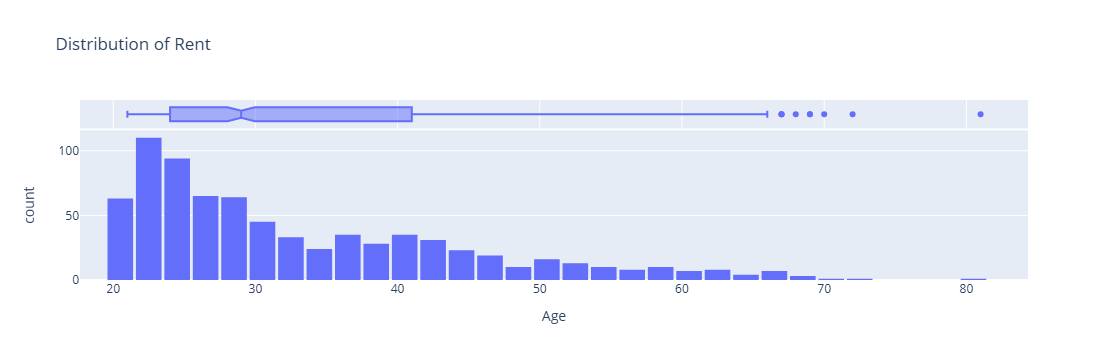

In [14]:
fig = px.histogram(df,
                   x='Age', 
                   marginal='box', 
                   title='Distribution of Rent')
fig.update_layout(bargap=0.1)
fig.show()

In [15]:
df_adjusted = df.copy()  # Create a copy to avoid modifying the original DataFrame
    
for column in df_adjusted.select_dtypes(include='number').columns:
    # Calculate Q1, Q3, and IQR
    Q1 = df_adjusted[column].quantile(0.25)
    Q3 = df_adjusted[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Adjust the values to bounds
    df_adjusted[column] = df_adjusted[column].clip(lower=lower_bound, upper=upper_bound)
    

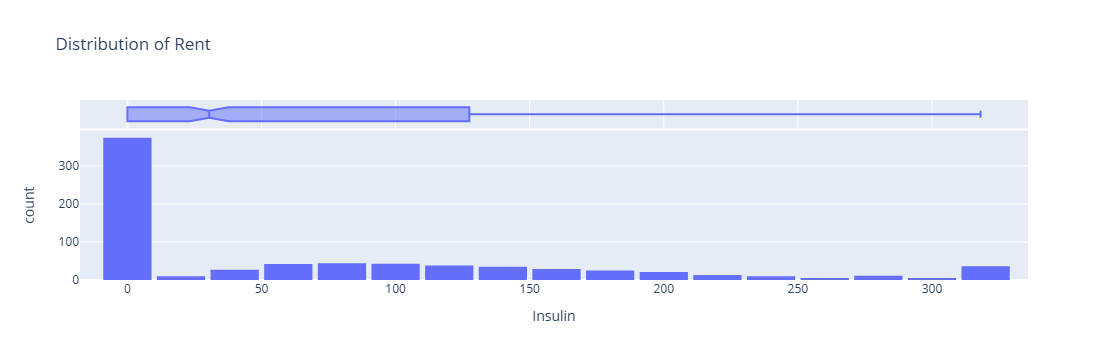

In [17]:
fig = px.histogram(df_adjusted,
                   x='Insulin', 
                   marginal='box', 
                   title='Distribution of Rent')
fig.update_layout(bargap=0.1)
fig.show()

In [18]:
df = df_adjusted

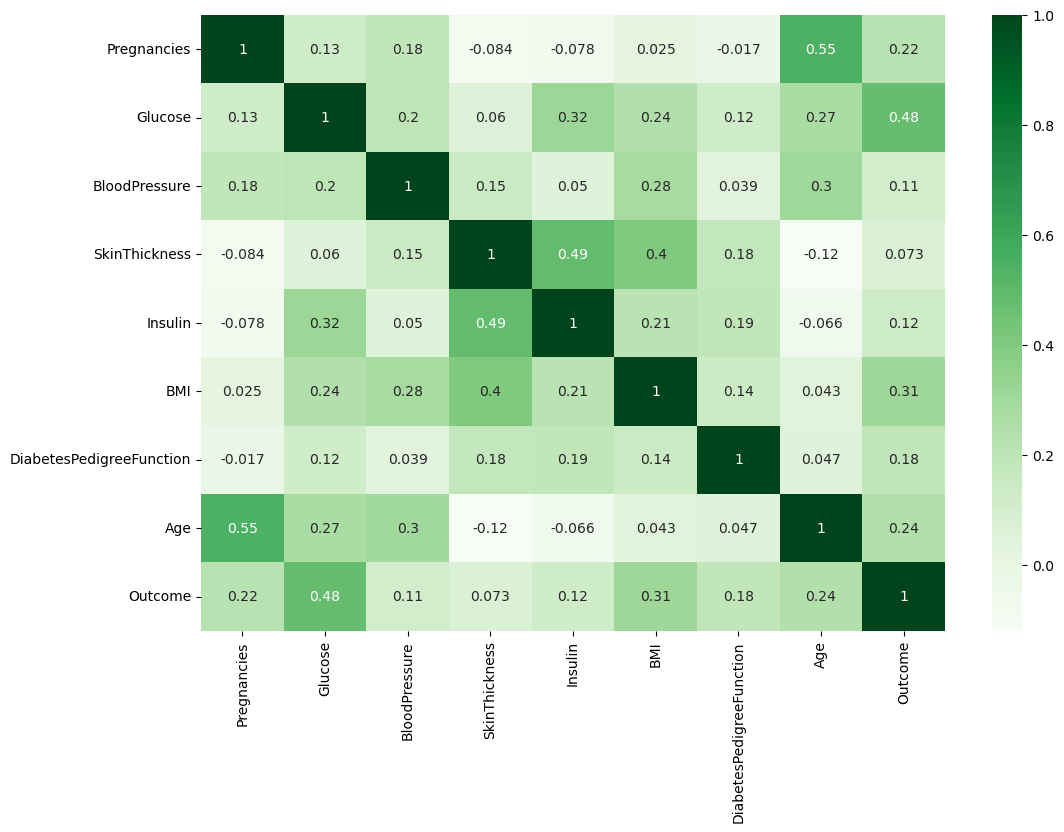

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Greens')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [22]:
input_cols = list(train_df.columns)[:-1]
target_col = 'Outcome'

In [23]:
X_train = train_df[input_cols]
train_targets = train_df[target_col]

X_val = val_df[input_cols]
val_targets = val_df[target_col]

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rf_model = RandomForestClassifier(n_estimators=2000, random_state=42)

In [46]:
rf_model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=2000, random_state=42)

In [47]:
train_preds = rf_model.predict(X_train)

In [48]:
from sklearn.metrics import accuracy_score

accuracy_score(train_targets, train_preds)

1.0

In [49]:
val_preds = rf_model.predict(X_val)

In [50]:
accuracy_score(val_preds, val_targets)

0.7467532467532467

In [53]:
from sklearn.model_selection import RandomizedSearchCV


In [54]:
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_distributions = {
    'n_estimators': [100, 200, 500, 1000, 1500, 2000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Set up Randomized Search
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=50,       # Number of random combinations to test
                                   scoring='accuracy', 
                                   cv=5,            # 5-fold cross-validation
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)       # Use all processors

# Fit the model
random_search.fit(X_train, train_targets)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the tuned model
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_val)
print("Accuracy on Test Set:", accuracy_score(val_targets, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Accuracy on Test Set: 0.7662337662337663
